In [40]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import trange
import cProfile
import pickle

num_particles = 2
N = num_particles
# The neural network structure (ignoring the number of inputs and the number of outputs)
structure = [100,200,300,300,200,100]
num_nodes = np.sum(structure)
# mass, hbar, and our frequencies are all set to 1
m = 1
hbar = 1
omega = 1
harmonic_omega = 1
# interaction strength of the delta function
g = -.5
g = 1
# interaction strength of the long-range potential
sigma = -g/2
# C is the symmetrization constant, as we increase the number of particles, we increase this 
# (otherwise when we symmetrize the coordinates, x_i^N will become too large) 
C = 6

FILENAME = "2_boson_energies_-5.csv"
PARAMS_FILE = "2_bosons_g-5.npy"

# when we start our chain of MCMC samples, this is the range of values that we draw the initial sample from
INITIAL_SAMPLE = jnp.array(np.random.uniform(-1, 1, N))

# class that defines a homebrew neural network
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Initialize weights and biases for each layer
        self.weights = []
        self.biases = []
        if hidden_sizes != [0]:
            sizes = [input_size] + hidden_sizes + [output_size]
        else:
            sizes = [input_size, output_size]

        for i in range(len(sizes) - 1):
            # generate the weights and biases from a random normal distribution
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            self.weights.append(w)
            self.biases.append(b)

    # this is the symmetrization function
    @partial(jit, static_argnums=(0,))
    def transform(self, coords):
        ret = jnp.zeros(num_particles)
        for i in range(num_particles):
            # we use the symmetrization constant C to prevent the sum from getting too large
            ret = ret.at[i].set(jnp.sum(jnp.power(coords/C, i + 1)))
        return ret 

    # querying the neural network, passing it coordinates and the flattened parameters (weights and biases)
    @partial(jit, static_argnums=(0,))
    def __call__(self, x, params):
        # this is the symmetrization step
        x = self.transform(x)
        # unflatten the parameters and set them as the weights and biases
        self.weights, self.biases = self.unflatten_params(params)
        a = x
        for i in range(len(self.weights) - 1):
            z = jnp.dot(a, self.weights[i]) + self.biases[i]
            a = celu(z)
        a = jnp.dot(a, self.weights[-1]) + self.biases[-1]
        return a[0][0]
    
    # This function flattens the weights and biases into a single array (which is the set of variational parameters)
    @partial(jit, static_argnums=(0,))
    def flatten_params(self):
        params = jnp.array([])
        for i in range(len(self.weights)):
            params = jnp.concatenate((params, self.weights[i].flatten()))
            params = jnp.concatenate((params, self.biases[i].flatten()))
        return jnp.array(params)
    # this takes the flattened parameters and unflattens them into weights and biases, which are used in the neural network
    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, params):
        weights = []
        biases = []
        start = 0
        for i in range(len(self.weights)):
            end = start + self.weights[i].size
            weights.append(jnp.reshape(jnp.array(params[start:end]), self.weights[i].shape))
            start = end
            end = start + self.biases[i].size
            biases.append(jnp.reshape(jnp.array(params[start:end]), self.biases[i].shape))
            start = end
        return weights, biases
    

# initialize the network
nn = NeuralNetwork(num_particles, structure, 1)

#=========================== ANSATZ ===========================
# function that we exponentiate to get the wavefunction
# the other term is there to force the wavefunction to 0 at infinity, allows us to train the network
@jit
def A(coords, params):
    return nn(coords, params) + omega * jnp.sum(coords**2)

# define the wavefunction
@jit
def psi(coords, params):
    return jnp.exp(-A(coords, params)) 

#=========================== MC SAMPLING ===========================
# does the accept/reject step of the Metropolis algorithm
@jit
def mcstep_E(xis, limit, positions, params):
    
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    newpositions = jnp.array(positions) + xis
    
    prob = psi(newpositions, params)**2./psi(positions, params)**2.
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

# gets a set of Monte Carlo samples from the wavefunction
# params is the flattened set of weights and biases
# Nsweeps is the number of samples that we want
# Ntherm is the number of thermalization steps (we discard the first Ntherm samples)
# keep is the number of steps we take before we record a sample (only keep every keep-th sample)
# stepsize is the size of the step we take in the Metropolis-Hastings algorithm (chosen so that the rate of acceptance is around 50%)
def sample(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=INITIAL_SAMPLE, progress=False):
    sq = []
    sq_prime = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    params = jax.device_put(params, device=jax.devices("cpu")[0])

    randoms = np.random.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = np.random.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in trange(0, num_total):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
    # generate the primed samples by going through every sample and making sample[N_up] = sample[0]
    sq_prime = sq.copy()
    for i in range(len(sq)):
        a = np.array(sq[i])
        a[1] = a[0]
        sq_prime[i] = jnp.array(a) 

    return jnp.array(sq), jnp.array(sq_prime), counter/num_total



# first derivative of the neural network with respect to the coordinates
# in Andy's notation this is dA/dx
dA_dx = jit(grad(A, 0))

# hessian is the matrix of second derivatives
A_hessian = jax.jacfwd(dA_dx, 0) 

# get the second derivative from the hessian by taking the diagonal
@jit
def d2A_dx2(coords, params):
    return jnp.diag(A_hessian(coords, params))


# Now we compute all of the different needed parts of the energy and gradient
@jit
def Hpsi(coords, coords_prime, params, alpha):
    return Hpsi_without_delta(coords, params) + delta_potential(coords,coords_prime, params, alpha)

# sigma (long range) interaction
@jit
def sigma_term(coords):
    N = num_particles 
    sigma_term = 0
    for i in range(N):
        for j in range(i,N):
            sigma_term += sigma* jnp.abs(coords[i] - coords[j])  
    return sigma_term


@jit
def Hpsi_without_delta(coords, params):
    return 1/(2*m) * (jnp.sum(d2A_dx2(coords, params)) - jnp.sum(dA_dx(coords, params)**2)) + m*.5*harmonic_omega**2* jnp.sum(coords**2) + sigma_term(coords)

@jit
def second_term(coords, params):
    return dnn_dtheta(coords, params) * Hpsi_without_delta(coords, params)

vsecond_term = jit(vmap(second_term, in_axes=(0, None), out_axes=0))

@jit
def third_term(coords,coords_prime, params, y_max):
    return dnn_dtheta(coords_prime, params) * delta_potential(coords, coords_prime, params, y_max)

vthird_term = jit(vmap(third_term, in_axes=(0,0, None, None), out_axes=0))

# delta function potential 
@jit
def delta_potential(coords, coords_prime, params, alpha):
    N = num_particles    
    # compute e^(-2 NN(params_prime))
    # ratio = jnp.exp(-2 * A(coords_prime, params) + 2 * A(coords, params))
    ratio = (psi(coords_prime, params)**2)/(psi(coords, params)**2)
    delta_dist = (1/(jnp.sqrt(jnp.pi) * alpha)) * jnp.exp(-(coords[1]**2)/(alpha**2))
    return g * N*(N-1)/2 * ratio * delta_dist

vdelta_potential = jit(vmap(delta_potential, in_axes=(0,0, None, None), out_axes=0))
venergy = jit(vmap(Hpsi, in_axes=(0,0, None, None), out_axes=0))
vHpsi_without_delta = jit(vmap(Hpsi_without_delta, in_axes=(0, None), out_axes=0))


# derivative of the neural network with respect to every parameter
# dA/d theta
dnn_dtheta = jit(grad(A, 1)) 
vdnn_dtheta = vmap(dnn_dtheta, in_axes=(0, None), out_axes=0)

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

#=========================== GRADIENT DESCENT ALGORITHM ===========================
def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0, verbose=False):
    # get the samples
    samples, samples_prime, _  = sample(params, num_samples, thermal, skip, variation_size)

    y_max = jnp.max(jnp.abs(jnp.array(samples[:,1])))
    alpha = y_max/(jnp.sqrt(-jnp.log(jnp.sqrt(jnp.pi) * 10**(-10))))

    psiHpsi = venergy(samples, samples_prime, params, alpha) 
    # Hpsi_terms_without_delta = vHpsi_without_delta(samples, params)
    # delta_term = vdelta_potential(samples,samples_prime, params, samples)

    # delta function additions
    dA_dtheta = vdnn_dtheta(samples, params)
    # dA_dtheta_repeated = vdnn_dtheta(samples_prime, params)

    dA_dtheta_avg = 1/num_samples * jnp.sum(dA_dtheta, 0)

    second_term = 1/num_samples * jnp.sum(vsecond_term(samples, params), 0)
    third_term = 1/num_samples * jnp.sum(vthird_term(samples, samples_prime, params, alpha), 0)
    # third_term =1/num_samples * jnp.sum(vboth(dA_dtheta_repeated,delta_term), 0)
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples)

    energy = 1/num_samples * jnp.sum(psiHpsi)

   
    if verbose:
        print(energy)

    gradient_calc = 2 * energy * dA_dtheta_avg - 2 * second_term - 2*third_term
    return gradient_calc, energy, uncert


# define a function that takes in samples, bins them, and returns the average of each bin
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts


# define a function that gets all samples, and then bins them with different bin sizes
def autocorrelation(params):
    samples = sample(params, num_samples=10**3, thermalization_steps=200, skip_count=40, variation_size=1)[0]
    energies = [Hpsi(s, params) for s in samples]
    
    bins = np.linspace(1, 100, 100, dtype=int)
    # now plot the average energy as a function of the number of bins
    us = []
    for b_size in bins:
        us.append(bin_samples(energies, b_size))
    plt.scatter(bins, us)
    plt.title("Bin size vs. Uncertainty")
    plt.xlabel("Bin size")
    plt.ylabel("Uncertainty")
    plt.show()

def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = []
    ns = np.arange(iterations)

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:
        new_params, energy, uncert = step(
            old_params, step_num, N, thermal, skip, variation_size
        )
        hs.append(energy)
        us.append(uncert)
        # write the energy to the file
        with open(FILENAME, mode="a") as f:
            f.write(str(energy) + "," + str(uncert) + "\n")
        with open(PARAMS_FILE, "wb") as f:
            jnp.save(f, new_params)
        old_params = new_params.copy()
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params

In [41]:
def find_step_size(params, start):
    lr = .1
    target = 0.5
    tolerance = .05
    max_it = 1000
    step = start
    best_step = start
    best_acc = 0
    it_num = 0
    # get the samples 
    _, _, acc = sample(params, 1000, 100, 10, step)
    # while the acceptance rate is not within +/- .5 of the target
    while (acc < target - tolerance or acc > target + tolerance) and it_num < max_it:
        it_num += 1
        # if the acceptance rate is too low, increase the step size
        if acc < target - tolerance:
            step -= lr
        # if the acceptance rate is too high, decrease the step size
        elif acc > target + tolerance:
            step += lr
        # if we cross the target, decrease the learning rate and go back
        if (acc < target and best_acc > target) or (acc > target and best_acc < target):
            lr /= 2
            step = best_step
        # keep track of the best step size
        if abs(acc - target) < abs(best_acc - target):
            best_acc = acc
            best_step = step
        
        # get the samples for the next step size
        _, _, acc = sample(params, 1000, 100, 10, step)
    print("step size:",best_step)
    return best_step

In [42]:
print("number of parameters" , len(nn.flatten_params()))
print("Log of parameters", np.log10(len(nn.flatten_params())))

number of parameters 251501
Log of parameters 5.400539716205539


In [31]:
samples = sample(nn.flatten_params(), 10000, 100, 10, 1, progress=True)

100%|██████████| 100101/100101 [00:33<00:00, 2995.38it/s]


In [43]:
open(FILENAME, 'w').close()

start_params = nn.flatten_params()

opt_init, opt_update, get_params = jax_opt.adam(10**(-3))

resultsa = train(start_params, 100, 500, 100, 10, find_step_size(start_params, .85))
# 0 -> energies
# 1 -> uncert
# 2 -> steps
# 3 -> params

step size: 0.85


Energy = 1.0437331: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


In [10]:
# opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsb = train(resultsa[3], 100, 2000, 500, 10, find_step_size(resultsa[3], 1))

step size: 1.3000000000000003


Energy = 0.86139846: 100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


In [12]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsc = train(resultsb[3], 10, 300000, 500, 3, find_step_size(resultsb[3], 1))

step size: 1.3500000000000003


Energy = 0.80155677: 100%|██████████| 10/10 [22:01<00:00, 132.18s/it]


In [ ]:
# opt_init, opt_update, get_params = jax_opt.adam(10**(-5))
# resultsd = train(resultsc[3], 25, 80000, 500, 5, find_step_size(resultsc[3], 1))


In [ ]:
# resultse = train(resultsd[3], 25, 100000, 500, 2, find_step_size(resultsd[3], 1))

In [ ]:
params = resultsc[3]

Minimum value:  1.044(26)
Fractional percent error:  39.2(3.4)
2.4485662


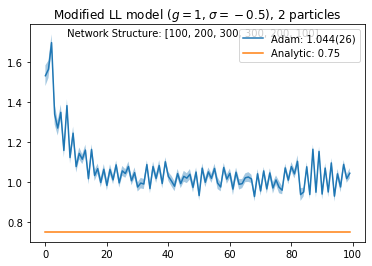

In [45]:
from scipy.special import comb
def harmonic_energy(n):
    return .5 + 2*n - np.sqrt(2/np.pi) * (n+1/2)/g

def astra_energy():
    return (N * omega)/2 - m * g**2  * (N*(N**2 - 1))/(24)


true_energy = .5 * hbar * omega * num_particles
true_energy = harmonic_energy(0)
true_energy = astra_energy()
#g = 1, sigma = -g/2
# true_energy = .75
# g = .1, sigma = 0:
# true_energy = 1.03881
# g= .8, sigma= -g
# true_energy = .9375
# true_energy = 0.3098

total_hists =  resultsa[0] 
# + resultsb[0] + resultsc[0] 
#  + resultsd[0] + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] 
# + resultsb[1]+ resultsc[1] 
# + resultsd[1] + resultse[1]
# + resultsd[1]

# get index of minimum value
min_val = np.min(total_hists)
min_val = total_hists[-1]
min_index = total_hists.index(min_val)
min_err = total_uncerts[min_index]
val = gv.gvar(min_val, min_err)
fractional_error = (val - true_energy)/true_energy
print("Minimum value: ", val)
print("Fractional percent error: ", fractional_error*100)
print(100*min_err/min_val)
plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam: " + str(val))
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
structure = nn.hidden_sizes
plt.annotate(" Network Structure: " + str(structure), xy=(0.1, 0.95), xycoords='axes fraction')
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"Analytic: " + str(round(true_energy,3)))
pdiff = (min_val - true_energy)/true_energy*100
# plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title(r"Modified LL model ($g = $" + str(g) + r", $\sigma =" + str(sigma) + "$), " + str(num_particles) + " particles")
# print(min_val)
# print(min_err)
plt.show()

In [ ]:
samples, samples_prime, _ = sample(params, 4*10**4, 100, 10, 1)
y_max = jnp.max(jnp.abs(jnp.array(samples[:,1])))
alpha = y_max/(jnp.sqrt(-jnp.log(jnp.sqrt(jnp.pi) * 10**(-10))))
energies = venergy(samples,samples_prime, params, alpha)
mean_energy = jnp.mean(energies)
print(mean_energy)

# bins = np.linspace(1, 100, 100, dtype=int)
bins = np.array([1,2,5,10,20,50,100,150,200,250,300,360,450,500,550,600,660,750,900,990,1100])
# now plot the average energy as a function of the number of bins
us = []
for b_size in bins:
    us.append(bin_samples(energies, b_size))
plt.scatter(bins, us)
plt.title("Bin size vs. Uncertainty")
plt.xlabel("Bin size")
plt.ylabel("Uncertainty")
print(max(us))
plt.show()

In [ ]:
final = gv.gvar(mean_energy, max(us))
print(final)

In [ ]:
xs = np.arange(-5, 5, .05)
ys = np.arange(-5, 5, .05)
wavs = []
for i in range(len(xs)):
    for j in range(len(ys)):
        wavs.append(psi(np.array([xs[i], ys[j]]), params)**2)


In [ ]:
X, Y = np.meshgrid(xs,ys)
Z = np.array(wavs).reshape(len(xs), len(ys))

In [ ]:
fig = plt.figure()
plt.contourf(X, Y, Z, 100)

plt.plot(xs,-xs)
plt.grid()
plt.show()

In [ ]:
# the exact wavefunction for the case where sigma = -g/2
@jit
def astra_wf(coords):
    ret = 1
    a_s = -2/(m*g) 
    a_ho = jnp.sqrt(1/(m * harmonic_omega))
    for i in range(N):
        for j in range(0,i):
            ret *= jnp.exp(-jnp.abs(coords[i] - coords[j])/a_s)
        ret *= jnp.exp(-coords[i]**2/(2*a_ho**2))
    return ret

# sampling from the exact wavefunction

@jit
def mcstep_E_exact(xis, limit, positions):
    newpositions = jnp.array(positions) + xis
    
    prob = astra_wf(newpositions)**2 / astra_wf(positions)**2
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

def sample_exact(Nsweeps, Ntherm, keep, stepsize, positions_initial=INITIAL_SAMPLE, progress=False):
    sq = []
    sq_prime = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 

    randoms = np.random.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = np.random.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E_exact(randoms[i], limits[i], positions_prev)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E_exact(randoms[i], limits[i], positions_prev)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
    # generate the primed samples by going through every sample and making sample[N_up] = sample[0]
    sq_prime = sq.copy()
    for i in range(len(sq)):
        a = np.array(sq[i])
        a[1] = a[0]
        sq_prime[i] = jnp.array(a) 

    return jnp.array(sq), jnp.array(sq_prime), counter/num_total

In [ ]:
samples = sample(params, 3 * 10**4, 100, 10, .85)
samples_exact = sample_exact(3 * 10**4, 100, 10, .85)

In [ ]:
def local_density(samples):
    x_bins = np.linspace(-9, 9, 72)
    dx = x_bins[1] - x_bins[0]  # Bin width
    n_x = np.zeros_like(x_bins)

    # bin the x_1s
    for x in samples[0][:,0]:
        n_x[np.digitize(x, x_bins)] += 1

    # Normalize
    n_x /= (dx * np.sum(n_x))

    return x_bins, n_x

x_bins, n_x = local_density(samples)
x_bins_exact, n_x_exact = local_density(samples_exact)
plt.plot(x_bins, n_x,'-o', markersize=2, color="red")
plt.plot(x_bins_exact, n_x_exact,'-o', markersize=2, color="black")
plt.title(r"$N = 2$ Local Density Profile")
plt.xlabel("$x$")

plt.ylim(0, 1)
plt.grid()
plt.ylabel("$n(x)/\int dx n(x)$")
plt.show()